#Gerar 10 folds para validação cruzada do conjunto de dados CStNews

Divide o conjunto de dados CSTNews em 10 folds. Cada fold possui 90% dos dados para treinamento e 10% para teste.

Os dados de teste não se repetem em cada fold.

O procedimento exclui os documentos que geram mais de 512 tokens.

----------------------------
**CSTNews 5.0:** https://sites.icmc.usp.br/taspardo/sucinto/files/CSTNews%205.0.zip

**Trabalho Marcio Dias:** https://sites.icmc.usp.br/taspardo/Summary%20coherence%20models.zip

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers


**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento
inicioProcessamento = time.time()

## 1.3 Tratamento de logs

In [ ]:
# Biblioteca de logging
import logging

# Formatando a mensagem de logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## 1.4 Identificando o ambiente Colab

In [ ]:
# Se estiver executando no Google Colaboratory
import sys

# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = 'google.colab' in sys.modules

## 1.5 Biblioteca de limpeza de tela

In [ ]:
from IPython.display import clear_output

## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount('/content/drive')     

Mounted at /content/drive


## 1.7 Instalação BERT da Hugging Face

Instala a interface pytorch para o BERT by Hugging Face. 

In [ ]:
!pip install -U transformers==4.5.1

     |████████████████████████████████| 2.1 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 49.9 MB/s 
     |████████████████████████████████| 3.3 MB 30.7 MB/s 


## 1.9 Recupera o cohebert do Github

In [ ]:
!git clone https://github.com/osmarbraz/cohebert_v1.git

Cloning into 'cohebert_v1'...
remote: Enumerating objects: 4765, done.
remote: Counting objects: 100% (397/397), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 4765 (delta 270), reused 252 (delta 142), pack-reused 4368
Receiving objects: 100% (4765/4765), 28.71 MiB | 10.49 MiB/s, done.
Resolving deltas: 100% (3025/3025), done.


In [ ]:
#Muda o diretório corrente para a pasta clonada
import sys
sys.path.append('./cohebert_v1/cohebert')

In [ ]:
# Import de bibliotecas
from util.utilmodulo import *
from util.utiltempo import *
from util.utilarquivo import *

# 2 Parametrização

In [ ]:
# # Biblioteca cohebert
from bert.bertarguments import ModeloArgumentosClassificacao

# Definição dos parâmetros do Modelo
model_args = ModeloArgumentosClassificacao(     
    max_seq_len = 512,
    pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",    
    #pretrained_model_name_or_path = 'bert-base-multilingual-cased',
    do_lower_case = False,
    output_hidden_states = False,
    fold = 10 # Quantidade folds a ser gerado
)

# 3 BERT

## Carrega o modelo e tokenizador BERT

Lista de modelos da comunidade:
* https://huggingface.co/models

Português(https://github.com/neuralmind-ai/portuguese-bert):  
* **'neuralmind/bert-base-portuguese-cased'**
* **'neuralmind/bert-large-portuguese-cased'**

In [ ]:
# Biblioteca cohebert
from bert.bertmodulo import *

# Carrega o modelo e tokenizador do BERT
model, tokenizer = carregaBERT(model_args)

2021-09-18 00:03:43,782 : INFO : Download do arquivo: bert-large-portuguese-cased_pytorch_checkpoint.zip.


  0%|          | 0.00/1.24G [00:00<?, ?B/s]

2021-09-18 00:05:26,501 : INFO : Download do arquivo: cohebert_v1/modeloBERT/vocab.txt.


  0%|          | 0.00/210k [00:00<?, ?B/s]

2021-09-18 00:05:27,257 : INFO : Diretório cohebert_v1/modeloBERT do modelo BERT pronta!
2021-09-18 00:05:27,421 : INFO : Usando modelo BERT pré-treinado.
2021-09-18 00:05:27,424 : INFO : Carregando o modelo BERT do diretório cohebert_v1/modeloBERT para classificação.
Some weights of the model checkpoint at cohebert_v1/modeloBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClas

# 4 Divisão dos Folds

## 4.1 Carregamento do arquivo



In [ ]:
# Biblioteca cohebert
from conjuntodedados.dadoscstnewsmedida import *

# Carrega os dados
dfdados = getConjuntoDeDadosMedida(model_args, tokenizer, None)

print("Conjunto de dados:", len(dfdados))

2021-09-18 00:05:37,381 : INFO : Realizando o download do CSTNews do meu OneDrive.
2021-09-18 00:05:40,078 : INFO : Download do arquivo: Summarycoherencemodels.zip.


  0%|          | 0.00/498M [00:00<?, ?B/s]

2021-09-18 00:06:05,918 : INFO : Geração de pares de documentos concluído: 5020.
2021-09-18 00:06:24,255 : INFO : NumExpr defaulting to 2 threads.
2021-09-18 00:06:24,275 : INFO : Quantidade de dados anterior: 5020.
2021-09-18 00:06:24,276 : INFO : Nova quantidade de dados    : 4980.
2021-09-18 00:06:24,336 : INFO : Quantidade de registros removidos: 40.


Conjunto de dados: 4980


Usaremos os pandas para analisar o conjunto de dados e examinar algumas de suas propriedades dos dados.

In [ ]:
dfdados.sample(5)

,idOriginal,sentencasOriginais,documentoOriginal,idPermutado,sentencasPermutadas,documentoPermutado
2071,C30_Extrato_3.txt,[SÃO PAULO - O Itaú obteve nos primeiros seis ...,SÃO PAULO - O Itaú obteve nos primeiros seis m...,C30_Extrato_3_Perm_11.txt,"[No segundo trimestre, o lucro do Itaú foi de ...","No segundo trimestre, o lucro do Itaú foi de R..."
917,C42_Extrato_5.txt,[O relator da segunda representação contra o s...,O relator da segunda representação contra o se...,C42_Extrato_5_Perm_17.txt,"[A expectativa, no entanto, é que o conselho s...","A expectativa, no entanto, é que o conselho si..."
726,C41_Extrato_5.txt,[Na manhã desta sexta-feira o nadador Thiago P...,Na manhã desta sexta-feira o nadador Thiago Pe...,C41_Extrato_5_Perm_6.txt,[Na manhã desta sexta-feira o nadador Thiago P...,Na manhã desta sexta-feira o nadador Thiago Pe...
4423,C17_Extrato_2.txt,[Após um fim de semana no Norte e Nordeste ao ...,Após um fim de semana no Norte e Nordeste ao l...,C17_Extrato_2_Perm_3.txt,"[O presidente Luiz Inácio Lula da Silva, candi...","O presidente Luiz Inácio Lula da Silva, candid..."
4159,C25_Extrato_6.txt,[RIO - Foi um domingo especial e inesquecível ...,RIO - Foi um domingo especial e inesquecível p...,C25_Extrato_6_Perm_19.txt,"[Os argentinos, com um time repleto de craques...","Os argentinos, com um time repleto de craques,..."


## 4.2 Analisando o comprimento do texto



In [ ]:
print(len(dfdados))

4980


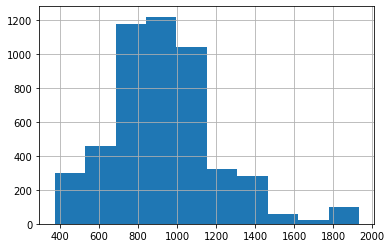

In [ ]:
dfdados['documentoOriginal'].apply(len).hist()

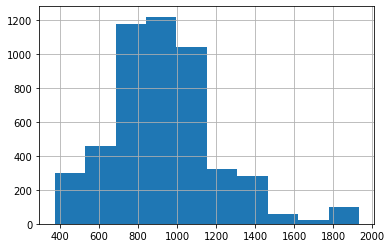

In [ ]:
dfdados['documentoPermutado'].apply(len).hist()

Procurando a maior quantidade de tokens no conjunto de dados

As células abaixo executará uma passagem de tokenização do conjunto de dados de treino, avaliação e teste para medir o comprimento máximo das documentos.

In [ ]:
maior_tamanho = 0

# Para cada documento no conjunto de treino.
for index, linha in dfdados.iterrows():        

    # Tokeniza o texto e adiciona os tokens `[CLS]` e `[SEP]`.
    input_ids = tokenizer.encode(linha['documentoOriginal'], add_special_tokens=True)

    # Atualiza o tamanho máximo de documento.
    maior_tamanho = max(maior_tamanho, len(input_ids))

print('Tamanho máximo de documento no conjunto de dados: {}'.format(maior_tamanho))

Tamanho máximo de documento no conjunto de dados: 467


## 4.3 Divisão em k folds

### 4.3.1 Realizando a divisão do conjunto de dados para treinamento e validação através do k folds

In [ ]:
# Biblioteca cohebert
from conjuntodedados.dadoscstnewsclassificacaokfold import *

# Diretório a ser criado
DIRETORIO_BASE = "/content/validacao_kfold"

# Registra o tempo inícial.
t0 = time.time()

# Gera os arquivos dos kfolds
gerarArquivosKFold(model_args, DIRETORIO_BASE, dfdados)

# Medida de quanto tempo levou a execução da geração.
geracao_time = formataTempo(time.time() - t0)

logging.info("Tempo gasto: {:}".format(geracao_time))

2021-09-18 00:06:45,221 : INFO : Diretório para receber os folds criado: /content/validacao_kfold.
2021-09-18 00:06:45,227 : INFO : Executando divisão do fold: 1, Total: 4980.
2021-09-18 00:06:45,229 : INFO : Treino: 4482, Teste: 498.
2021-09-18 00:06:45,501 : INFO : Executando divisão do fold: 2, Total: 4980.
2021-09-18 00:06:45,504 : INFO : Treino: 4482, Teste: 498.
2021-09-18 00:06:45,780 : INFO : Executando divisão do fold: 3, Total: 4980.
2021-09-18 00:06:45,782 : INFO : Treino: 4482, Teste: 498.
2021-09-18 00:06:46,046 : INFO : Executando divisão do fold: 4, Total: 4980.
2021-09-18 00:06:46,048 : INFO : Treino: 4482, Teste: 498.
2021-09-18 00:06:46,331 : INFO : Executando divisão do fold: 5, Total: 4980.
2021-09-18 00:06:46,333 : INFO : Treino: 4482, Teste: 498.
2021-09-18 00:06:46,600 : INFO : Executando divisão do fold: 6, Total: 4980.
2021-09-18 00:06:46,603 : INFO : Treino: 4482, Teste: 498.
2021-09-18 00:06:46,876 : INFO : Executando divisão do fold: 7, Total: 4980.
2021-09-

### 4.3.2 Analisando os dados gerados na divisão

In [ ]:
# Biblioteca cohebert
from conjuntodedados.dadoscstnewsclassificacaokfold import *

# Diretório a ser criado
DIRETORIO_BASE = '/content/validacao_kfold'

# Analisa os arquivos dos arquivos dos kfolds
analiseArquivosKFold(model_args, DIRETORIO_BASE, tokenizer)

2021-09-18 00:06:47,961 : INFO : Análise dos dados dos arquivos dos KFolds do diretório: /content/validacao_kfold.
2021-09-18 00:06:48,061 : INFO : Dados treino do fold 1: 8964.
2021-09-18 00:06:48,078 : INFO : Dados teste do fold 1: 996.


Máximo de tokens no conjunto de dados de treino: 467.


2021-09-18 00:07:23,587 : INFO : Máximo de token no conjunto de dados de teste: 467.
2021-09-18 00:07:23,594 : INFO : Fold 1 Treino positivos: 4482 de 8964 (50.00%).
2021-09-18 00:07:23,596 : INFO : Fold 1 Treino negativos: 4482 de 8964 (50.00%).
2021-09-18 00:07:23,601 : INFO : Fold 1 Teste positivos: 498 de 996 (50.00%).
2021-09-18 00:07:23,605 : INFO : Fold 1 Teste negativos: 498 de 996 (50.00%).
2021-09-18 00:07:23,608 : INFO : 
2021-09-18 00:07:23,700 : INFO : Dados treino do fold 2: 8964.
2021-09-18 00:07:23,717 : INFO : Dados teste do fold 2: 996.


Máximo de tokens no conjunto de dados de treino: 467.


2021-09-18 00:07:58,943 : INFO : Máximo de token no conjunto de dados de teste: 467.
2021-09-18 00:07:58,949 : INFO : Fold 2 Treino positivos: 4482 de 8964 (50.00%).
2021-09-18 00:07:58,952 : INFO : Fold 2 Treino negativos: 4482 de 8964 (50.00%).
2021-09-18 00:07:58,956 : INFO : Fold 2 Teste positivos: 498 de 996 (50.00%).
2021-09-18 00:07:58,959 : INFO : Fold 2 Teste negativos: 498 de 996 (50.00%).
2021-09-18 00:07:58,962 : INFO : 
2021-09-18 00:07:59,052 : INFO : Dados treino do fold 3: 8964.
2021-09-18 00:07:59,070 : INFO : Dados teste do fold 3: 996.


Máximo de tokens no conjunto de dados de treino: 467.


2021-09-18 00:08:34,155 : INFO : Máximo de token no conjunto de dados de teste: 467.
2021-09-18 00:08:34,159 : INFO : Fold 3 Treino positivos: 4482 de 8964 (50.00%).
2021-09-18 00:08:34,162 : INFO : Fold 3 Treino negativos: 4482 de 8964 (50.00%).
2021-09-18 00:08:34,165 : INFO : Fold 3 Teste positivos: 498 de 996 (50.00%).
2021-09-18 00:08:34,167 : INFO : Fold 3 Teste negativos: 498 de 996 (50.00%).
2021-09-18 00:08:34,170 : INFO : 
2021-09-18 00:08:34,259 : INFO : Dados treino do fold 4: 8964.
2021-09-18 00:08:34,276 : INFO : Dados teste do fold 4: 996.


Máximo de tokens no conjunto de dados de treino: 467.


2021-09-18 00:09:09,279 : INFO : Máximo de token no conjunto de dados de teste: 401.
2021-09-18 00:09:09,281 : INFO : Fold 4 Treino positivos: 4482 de 8964 (50.00%).
2021-09-18 00:09:09,284 : INFO : Fold 4 Treino negativos: 4482 de 8964 (50.00%).
2021-09-18 00:09:09,286 : INFO : Fold 4 Teste positivos: 498 de 996 (50.00%).
2021-09-18 00:09:09,289 : INFO : Fold 4 Teste negativos: 498 de 996 (50.00%).
2021-09-18 00:09:09,291 : INFO : 
2021-09-18 00:09:09,391 : INFO : Dados treino do fold 5: 8964.
2021-09-18 00:09:09,408 : INFO : Dados teste do fold 5: 996.


Máximo de tokens no conjunto de dados de treino: 467.


2021-09-18 00:09:44,274 : INFO : Máximo de token no conjunto de dados de teste: 467.
2021-09-18 00:09:44,277 : INFO : Fold 5 Treino positivos: 4482 de 8964 (50.00%).
2021-09-18 00:09:44,281 : INFO : Fold 5 Treino negativos: 4482 de 8964 (50.00%).
2021-09-18 00:09:44,285 : INFO : Fold 5 Teste positivos: 498 de 996 (50.00%).
2021-09-18 00:09:44,289 : INFO : Fold 5 Teste negativos: 498 de 996 (50.00%).
2021-09-18 00:09:44,291 : INFO : 
2021-09-18 00:09:44,381 : INFO : Dados treino do fold 6: 8964.
2021-09-18 00:09:44,397 : INFO : Dados teste do fold 6: 996.


Máximo de tokens no conjunto de dados de treino: 467.


2021-09-18 00:10:19,351 : INFO : Máximo de token no conjunto de dados de teste: 467.
2021-09-18 00:10:19,354 : INFO : Fold 6 Treino positivos: 4482 de 8964 (50.00%).
2021-09-18 00:10:19,357 : INFO : Fold 6 Treino negativos: 4482 de 8964 (50.00%).
2021-09-18 00:10:19,360 : INFO : Fold 6 Teste positivos: 498 de 996 (50.00%).
2021-09-18 00:10:19,363 : INFO : Fold 6 Teste negativos: 498 de 996 (50.00%).
2021-09-18 00:10:19,366 : INFO : 
2021-09-18 00:10:19,462 : INFO : Dados treino do fold 7: 8964.
2021-09-18 00:10:19,479 : INFO : Dados teste do fold 7: 996.


Máximo de tokens no conjunto de dados de treino: 467.


2021-09-18 00:10:54,499 : INFO : Máximo de token no conjunto de dados de teste: 467.
2021-09-18 00:10:54,501 : INFO : Fold 7 Treino positivos: 4482 de 8964 (50.00%).
2021-09-18 00:10:54,508 : INFO : Fold 7 Treino negativos: 4482 de 8964 (50.00%).
2021-09-18 00:10:54,510 : INFO : Fold 7 Teste positivos: 498 de 996 (50.00%).
2021-09-18 00:10:54,518 : INFO : Fold 7 Teste negativos: 498 de 996 (50.00%).
2021-09-18 00:10:54,519 : INFO : 
2021-09-18 00:10:54,608 : INFO : Dados treino do fold 8: 8964.
2021-09-18 00:10:54,626 : INFO : Dados teste do fold 8: 996.


Máximo de tokens no conjunto de dados de treino: 467.


2021-09-18 00:11:30,244 : INFO : Máximo de token no conjunto de dados de teste: 467.
2021-09-18 00:11:30,246 : INFO : Fold 8 Treino positivos: 4482 de 8964 (50.00%).
2021-09-18 00:11:30,248 : INFO : Fold 8 Treino negativos: 4482 de 8964 (50.00%).
2021-09-18 00:11:30,255 : INFO : Fold 8 Teste positivos: 498 de 996 (50.00%).
2021-09-18 00:11:30,258 : INFO : Fold 8 Teste negativos: 498 de 996 (50.00%).
2021-09-18 00:11:30,262 : INFO : 
2021-09-18 00:11:30,358 : INFO : Dados treino do fold 9: 8964.
2021-09-18 00:11:30,377 : INFO : Dados teste do fold 9: 996.


Máximo de tokens no conjunto de dados de treino: 467.


2021-09-18 00:12:06,240 : INFO : Máximo de token no conjunto de dados de teste: 467.
2021-09-18 00:12:06,245 : INFO : Fold 9 Treino positivos: 4482 de 8964 (50.00%).
2021-09-18 00:12:06,247 : INFO : Fold 9 Treino negativos: 4482 de 8964 (50.00%).
2021-09-18 00:12:06,253 : INFO : Fold 9 Teste positivos: 498 de 996 (50.00%).
2021-09-18 00:12:06,258 : INFO : Fold 9 Teste negativos: 498 de 996 (50.00%).
2021-09-18 00:12:06,260 : INFO : 
2021-09-18 00:12:06,357 : INFO : Dados treino do fold 10: 8964.
2021-09-18 00:12:06,375 : INFO : Dados teste do fold 10: 996.


Máximo de tokens no conjunto de dados de treino: 467.


2021-09-18 00:12:42,526 : INFO : Máximo de token no conjunto de dados de teste: 467.
2021-09-18 00:12:42,529 : INFO : Fold 10 Treino positivos: 4482 de 8964 (50.00%).
2021-09-18 00:12:42,531 : INFO : Fold 10 Treino negativos: 4482 de 8964 (50.00%).
2021-09-18 00:12:42,541 : INFO : Fold 10 Teste positivos: 498 de 996 (50.00%).
2021-09-18 00:12:42,544 : INFO : Fold 10 Teste negativos: 498 de 996 (50.00%).
2021-09-18 00:12:42,548 : INFO : 


### 4.3.3 Compacta e copia os arquivos do fold para o GoogleDrive

In [ ]:
#!cp '/content/validacao_kfold/'cstnews_*.* '/content/drive/My Drive/Colab Notebooks/Data/CSTNEWS/validacao_classificacao/kfold'

print("Terminei a cópia!")

Terminei a cópia!


Compacta os arquivos em dos folds

A opção `-jr` do zip compacta os arquivos ignorando a estrutura de diretório.

In [ ]:
!zip -jr '/content/validacao_kfold/'CSTNEWS_MD_KFOLD_10.zip 'validacao_kfold/'cstnews_*.*

print("Terminei a compactação!")

  adding: cstnews_md_test_f10.csv (deflated 89%)
  adding: cstnews_md_test_f1.csv (deflated 89%)
  adding: cstnews_md_test_f2.csv (deflated 89%)
  adding: cstnews_md_test_f3.csv (deflated 89%)
  adding: cstnews_md_test_f4.csv (deflated 89%)
  adding: cstnews_md_test_f5.csv (deflated 89%)
  adding: cstnews_md_test_f6.csv (deflated 89%)
  adding: cstnews_md_test_f7.csv (deflated 89%)
  adding: cstnews_md_test_f8.csv (deflated 89%)
  adding: cstnews_md_test_f9.csv (deflated 89%)
  adding: cstnews_md_train_f10.csv (deflated 97%)
  adding: cstnews_md_train_f1.csv (deflated 97%)
  adding: cstnews_md_train_f2.csv (deflated 97%)
  adding: cstnews_md_train_f3.csv (deflated 97%)
  adding: cstnews_md_train_f4.csv (deflated 97%)
  adding: cstnews_md_train_f5.csv (deflated 97%)
  adding: cstnews_md_train_f6.csv (deflated 97%)
  adding: cstnews_md_train_f7.csv (deflated 97%)
  adding: cstnews_md_train_f8.csv (deflated 97%)
  adding: cstnews_md_train_f9.csv (deflated 97%)
Terminei a compactação!


Copia o arquivo compactado para o google drive

In [ ]:
#!cp '/content/validacao_kfold/'CSTNEWS_MD_KFOLD_10.zip '/content/drive/My Drive/Colab Notebooks/Data/CSTNEWS/validacao_classificacao/kfold'

print("Terminei a cópia!")

Terminei a cópia!


# 5 Finalização

## 5.1 Tempo final de processamento



In [ ]:
 # Pega o tempo atual menos o tempo do início do processamento.
finalProcessamento = time.time()
tempoTotalProcessamento = formataTempo(finalProcessamento - inicioProcessamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempoTotalProcessamento))


  Tempo processamento:  0:15:08 (h:mm:ss)
